# FairSHAP API Usage Guide

This notebook demonstrates how to use the new FairSHAP API for one-shot data modification and fairness improvement.

## Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Data Loading and Preprocessing](#2-data-loading-and-preprocessing)
3. [Model Training](#3-model-training)
4. [One-Shot Modification with FairSHAP](#4-one-shot-modification-with-fairshap)
   - [Binary Sensitive Attribute Example](#41-binary-sensitive-attribute-example)
   - [Multi Sensitive Attribute Example](#42-multi-sensitive-attribute-example)
5. [Advanced Usage](#5-advanced-usage)
6. [Results Analysis and Visualization](#6-results-analysis-and-visualization)

## 1. Environment Setup

In [31]:
%reload_ext autoreload
%autoreload 2

In [32]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Import data loader and FairSHAP
from src.dataloader.unified_dataloader import load_dataset
from src.fairshap import FairSHAP

# Set random seed for reproducibility
np.random.seed(25)

print("Environment setup complete!")

Environment setup complete!


## 2. Data Loading and Preprocessing

In [33]:
# Load Compas dataset
print("Loading Compas dataset...")
a, processed_compas = load_dataset('compas')
print(f"Dataset loaded! Shape: {processed_compas.shape}")

Loading Compas dataset...
Dataset loaded! Shape: (7214, 19)


In [34]:
# View first few rows
processed_compas.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1
3,1,-0.994103,-0.141855,1.873571,-0.218065,-0.506414,1,0,0,0,0,0,1,0,1,1,0,0,0
4,1,0.688252,-0.141855,-0.187414,-0.218065,-0.301588,0,0,0,0,0,1,1,0,1,0,1,0,0


In [35]:
# Separate features and labels
df = processed_compas.copy()
# Uncomment the following line to use a sample of the data
# df = processed_compas.sample(frac=0.2, random_state=25)  # Use 20% of the data

X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Feature matrix shape: (7214, 18)
Label vector shape: (7214,)

Feature columns: ['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'c_charge_degree_F', 'c_charge_degree_M', 'type_of_assessment_Risk of Recidivism', 'score_text_High', 'score_text_Low', 'score_text_Medium']


In [37]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y  # Maintain label distribution
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set label distribution:")
print(y_train.value_counts())
print(f"\nTest set label distribution:")
print(y_test.value_counts())

Training set size: 5771 samples
Test set size: 1443 samples

Training set label distribution:
two_year_recid
0    3170
1    2601
Name: count, dtype: int64

Test set label distribution:
two_year_recid
0    793
1    650
Name: count, dtype: int64


## 3. Model Training

In [38]:
# Initialize XGBoost classifier
print("Initializing XGBoost model...")
model = XGBClassifier(
    random_state=25,
    eval_metric='logloss'  # Avoid warnings
)

# Train the model
print("Training model...")
model.fit(X_train, y_train)
print("Model training complete!")

Initializing XGBoost model...
Training model...
Model training complete!


In [39]:
# Evaluate original model performance
y_pred = model.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)

print(f"Original model accuracy: {original_accuracy:.4f}")

Original model accuracy: 0.6618


## 4. One-Shot Modification with FairSHAP

FairSHAP provides two new APIs:
- `modify_binary_once()`: For binary sensitive attributes (e.g., sex in COMPAS dataset)
- `modify_multi_once()`: For multi-valued sensitive attributes (e.g., race in COMPAS dataset)

### 4.1 Binary Sensitive Attribute Example

Using the Adult dataset as an example, where the sensitive attribute is `sex` (binary: male/female)

In [40]:
# Initialize FairSHAP
print("Initializing FairSHAP...")
fairshap = FairSHAP(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    dataset_name='compas',  # Dataset name
    matching_method='NN'   # Matching method: 'NN' (Nearest Neighbor) or 'OT' (Optimal Transport)
)
print("FairSHAP initialization complete!")

Initializing FairSHAP...
FairSHAP initialization complete!


In [41]:
# Perform one-shot modification using modify_binary_once
print("\n" + "="*80)
print("Starting FairSHAP one-shot modification...")
print("="*80 + "\n")

result = fairshap.modify_binary_once(
    threshold=0.05,  # SHAP value threshold - features above this will be modified
    return_modified_features=True  # Return modified training data
)


Starting FairSHAP one-shot modification...

FairSHAP Binary One-Shot Modification (threshold=0.05)
1. Split the compas dataset into majority/minority groups by sensitive attribute and label
   X_train_majority_label0 shape: (2460, 18)
   X_train_majority_label1 shape: (2207, 18)
   X_train_minority_label0 shape: (710, 18)
   X_train_minority_label1 shape: (394, 18)
2. Initialize FairnessExplainer
3. Process minority group (match and compute SHAP values)
4. Process majority group (match and compute SHAP values)
   SHAP computation completed in 19.53 seconds
5. Combine SHAP values and filter by threshold
   Found 1364 features with SHAP values > 0.05
6. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6618, DR: 0.0940, DP: 0.1751, EO: 0.1795, PQP: 0.0625
7. Apply all 1364 modifications
8. Train new model with modified data
9. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6459, DR: 0.0663, DP: 0.1312, EO: 0.1026, PQP: 0.0540

SUMMARY


In [42]:
# View results
print("\n" + "="*80)
print("Results Analysis")
print("="*80)

print(f"\nTotal modifications applied: {result['num_modifications']}\n")

print("Original model metrics:")
for metric, value in result['original_metrics'].items():
    print(f"  {metric:10s}: {value:.4f}")

print("\nModified model metrics:")
for metric, value in result['modified_metrics'].items():
    print(f"  {metric:10s}: {value:.4f}")

print("\nMetric changes:")
for metric in result['original_metrics'].keys():
    original = result['original_metrics'][metric]
    modified = result['modified_metrics'][metric]
    change = modified - original
    print(f"  {metric:10s}: {change:+.4f}")


Results Analysis

Total modifications applied: 1364

Original model metrics:
  accuracy  : 0.6618
  DR        : 0.0940
  DP        : 0.1751
  EO        : 0.1795
  PQP       : 0.0625

Modified model metrics:
  accuracy  : 0.6459
  DR        : 0.0663
  DP        : 0.1312
  EO        : 0.1026
  PQP       : 0.0540

Metric changes:
  accuracy  : -0.0159
  DR        : -0.0277
  DP        : -0.0440
  EO        : -0.0769
  PQP       : -0.0086


In [43]:
# Get modified training data
X_train_modified = result['modified_X_train']
y_train_modified = result['modified_y_train']

print(f"Modified training set shape: {X_train_modified.shape}")
print(f"Modified labels shape: {y_train_modified.shape}")

# This data can be used for:
# 1. Retraining models
# 2. Saving as new dataset
# 3. Further analysis

Modified training set shape: (5771, 18)
Modified labels shape: (5771,)


### 4.2 Multi Sensitive Attribute Example

For datasets with multi-valued sensitive attributes (e.g., COMPAS race with 6 categories)

In [44]:
# Load COMPAS multi-race dataset example
print("Loading COMPAS multi-race dataset...")
_, processed_compas = load_dataset('compas4multirace')

# Separate features and labels
df_compas = processed_compas.copy()
X_compas = df_compas.drop('two_year_recid', axis=1)
y_compas = df_compas['two_year_recid']

# Split into training and test sets
X_train_compas, X_test_compas, y_train_compas, y_test_compas = train_test_split(
    X_compas, y_compas,
    test_size=0.2,
    random_state=42,
    stratify=y_compas
)

# Train model
model_compas = XGBClassifier(random_state=42, eval_metric='logloss')
model_compas.fit(X_train_compas, y_train_compas)

print("COMPAS dataset preparation complete!")

Loading COMPAS multi-race dataset...
COMPAS dataset preparation complete!


In [45]:
# Initialize FairSHAP for multi-group
fairshap_multi = FairSHAP(
    model=model_compas,
    X_train=X_train_compas,
    y_train=y_train_compas,
    X_test=X_test_compas,
    y_test=y_test_compas,
    dataset_name='compas4multirace',  # Multi-race dataset
    matching_method='NN'
)

# Perform one-shot modification
result_multi = fairshap_multi.modify_multi_once(
    threshold=0.05,
    return_modified_features=True
)

FairSHAP Multi-Group One-Shot Modification (threshold=0.05)
1. Split the compas4multirace dataset by sensitive attribute values
2. Initialize FairnessExplainer
3. Compute SHAP values for privileged and unprivileged groups
   SHAP computation completed in 15.60 seconds
4. Filter SHAP values by threshold
   Found 2702 features with SHAP values > 0.05
5. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6653, DR: 0.0955
   Original fairness - DP_gap: 0.1545, EO_gap: 0.1346, PQ_gap: 0.0591
6. Apply all 2702 modifications
7. Train new model with modified data
8. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6549, DR: 0.0676
   Modified fairness - DP_gap: 0.1744, EO_gap: 0.1683, PQ_gap: 0.0744

SUMMARY
Modifications applied: 2702

Accuracy:  0.6653 → 0.6549 (Δ = -0.0104)
DR:        0.0955 → 0.0676 (Δ = -0.0278)

Binary Group Gaps:
  DP gap:  0.1545 → 0.1744 (Δ = +0.0199)
  EO gap:  0.1346 → 0.1683 (Δ = +0.0337)
  PQ gap:  0.0591 → 0.0744 (

In [47]:
# View multi-group fairness metrics
print("\n" + "="*80)
print("Multi-Group Fairness Metrics Comparison")
print("="*80)

print(f"\nTotal modifications applied: {result_multi['num_modifications']}\n")

# Basic metrics
print("Basic metrics:")
print(f"  Accuracy: {result_multi['original_metrics']['accuracy']:.4f} → "
      f"{result_multi['modified_metrics']['accuracy']:.4f} "
      f"(Δ = {result_multi['modified_metrics']['accuracy'] - result_multi['original_metrics']['accuracy']:+.4f})")
print(f"  DR:       {result_multi['original_metrics']['DR']:.4f} → "
      f"{result_multi['modified_metrics']['DR']:.4f} "
      f"(Δ = {result_multi['modified_metrics']['DR'] - result_multi['original_metrics']['DR']:+.4f})")

# Binary group gaps
print("\nBinary group fairness gaps:")
for metric in ['dp_gap', 'eo_gap', 'pq_gap']:
    original = result_multi['original_metrics'][metric]
    modified = result_multi['modified_metrics'][metric]
    change = modified - original
    print(f"  {metric:10s}: {original:.4f} → {modified:.4f} (Δ = {change:+.4f})")

# Multi-group metrics
print("\nMulti-group fairness metrics:")
for metric in ['dp_max', 'dp_avg', 'eo_max', 'eo_avg', 'pqp_max', 'pqp_avg']:
    original = result_multi['original_metrics'][metric]
    modified = result_multi['modified_metrics'][metric]
    change = modified - original
    print(f"  {metric:10s}: {original:.4f} → {modified:.4f} (Δ = {change:+.4f})")


Multi-Group Fairness Metrics Comparison

Total modifications applied: 2702

Basic metrics:
  Accuracy: 0.6653 → 0.6549 (Δ = -0.0104)
  DR:       0.0955 → 0.0676 (Δ = -0.0278)

Binary group fairness gaps:
  dp_gap    : 0.1545 → 0.1744 (Δ = +0.0199)
  eo_gap    : 0.1346 → 0.1683 (Δ = +0.0337)
  pq_gap    : 0.0591 → 0.0744 (Δ = +0.0153)

Multi-group fairness metrics:
  dp_max    : 0.1597 → 0.1328 (Δ = -0.0269)
  dp_avg    : 0.1252 → 0.1043 (Δ = -0.0210)
  eo_max    : 0.1944 → 0.4646 (Δ = +0.2703)
  eo_avg    : 0.1062 → 0.1722 (Δ = +0.0661)
  pqp_max   : 0.3391 → 0.3603 (Δ = +0.0212)
  pqp_avg   : 0.1436 → 0.1503 (Δ = +0.0067)


## 5. Advanced Usage

### 5.1 Testing Different Threshold Values

In [48]:
# Test multiple threshold values
thresholds = [0.01, 0.03, 0.05, 0.08, 0.10]
results_comparison = []

print("Testing different threshold values...\n")

for thresh in thresholds:
    print(f"Testing threshold = {thresh}...")
    result = fairshap.modify_binary_once(
        threshold=thresh,
        return_modified_features=False  # Don't return data to speed up
    )
    results_comparison.append({
        'threshold': thresh,
        'num_modifications': result['num_modifications'],
        'accuracy': result['modified_metrics']['accuracy'],
        'DR': result['modified_metrics']['DR'],
        'DP': result['modified_metrics']['DP'],
        'EO': result['modified_metrics']['EO'],
        'PQP': result['modified_metrics']['PQP']
    })

# Convert to DataFrame for easier viewing
df_comparison = pd.DataFrame(results_comparison)
print("\nComparison of different thresholds:")
print(df_comparison.to_string(index=False))

Testing different threshold values...

Testing threshold = 0.01...
FairSHAP Binary One-Shot Modification (threshold=0.01)
1. Split the compas dataset into majority/minority groups by sensitive attribute and label
   X_train_majority_label0 shape: (2460, 18)
   X_train_majority_label1 shape: (2207, 18)
   X_train_minority_label0 shape: (710, 18)
   X_train_minority_label1 shape: (394, 18)
2. Initialize FairnessExplainer
3. Process minority group (match and compute SHAP values)
4. Process majority group (match and compute SHAP values)
   SHAP computation completed in 18.02 seconds
5. Combine SHAP values and filter by threshold
   Found 2907 features with SHAP values > 0.01
6. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6618, DR: 0.0940, DP: 0.1751, EO: 0.1795, PQP: 0.0625
7. Apply all 2907 modifications
8. Train new model with modified data
9. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6334, DR: 0.0537, DP: 0.1250, EO: 0.0980,

### 5.2 Retraining Model with Modified Data

In [49]:
# Get modified data with best threshold
best_result = fairshap.modify_binary_once(
    threshold=0.05,
    return_modified_features=True
)

X_train_fair = best_result['modified_X_train']
y_train_fair = best_result['modified_y_train']

# Train new model
model_fair = XGBClassifier(random_state=42, eval_metric='logloss')
model_fair.fit(X_train_fair, y_train_fair)

# Evaluate on test set
y_pred_fair = model_fair.predict(X_test)
accuracy_fair = accuracy_score(y_test, y_pred_fair)

print(f"Accuracy of model trained on modified data: {accuracy_fair:.4f}")
print(f"Original model accuracy: {original_accuracy:.4f}")
print(f"Accuracy change: {accuracy_fair - original_accuracy:+.4f}")

FairSHAP Binary One-Shot Modification (threshold=0.05)
1. Split the compas dataset into majority/minority groups by sensitive attribute and label
   X_train_majority_label0 shape: (2460, 18)
   X_train_majority_label1 shape: (2207, 18)
   X_train_minority_label0 shape: (710, 18)
   X_train_minority_label1 shape: (394, 18)
2. Initialize FairnessExplainer
3. Process minority group (match and compute SHAP values)
4. Process majority group (match and compute SHAP values)
   SHAP computation completed in 18.31 seconds
5. Combine SHAP values and filter by threshold
   Found 1364 features with SHAP values > 0.05
6. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6618, DR: 0.0940, DP: 0.1751, EO: 0.1795, PQP: 0.0625
7. Apply all 1364 modifications
8. Train new model with modified data
9. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6459, DR: 0.0663, DP: 0.1312, EO: 0.1026, PQP: 0.0540

SUMMARY
Modifications applied: 1364
Accuracy change: 

### 5.3 Saving Modified Data

In [50]:
# Save modified training data
result = fairshap.modify_binary_once(
    threshold=0.05,
    return_modified_features=True
)

# Combine features and labels
modified_data = result['modified_X_train'].copy()
modified_data['income'] = result['modified_y_train']

# Save to CSV
modified_data.to_csv('adult_fairshap_modified_threshold_0.05.csv', index=False)
print("Modified data saved to: adult_fairshap_modified_threshold_0.05.csv")

FairSHAP Binary One-Shot Modification (threshold=0.05)
1. Split the compas dataset into majority/minority groups by sensitive attribute and label
   X_train_majority_label0 shape: (2460, 18)
   X_train_majority_label1 shape: (2207, 18)
   X_train_minority_label0 shape: (710, 18)
   X_train_minority_label1 shape: (394, 18)
2. Initialize FairnessExplainer
3. Process minority group (match and compute SHAP values)
4. Process majority group (match and compute SHAP values)
   SHAP computation completed in 18.17 seconds
5. Combine SHAP values and filter by threshold
   Found 1364 features with SHAP values > 0.05
6. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6618, DR: 0.0940, DP: 0.1751, EO: 0.1795, PQP: 0.0625
7. Apply all 1364 modifications
8. Train new model with modified data
9. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6459, DR: 0.0663, DP: 0.1312, EO: 0.1026, PQP: 0.0540

SUMMARY
Modifications applied: 1364
Accuracy change: 

## 6. Results Analysis and Visualization

### 6.1 Visualizing Threshold Impact

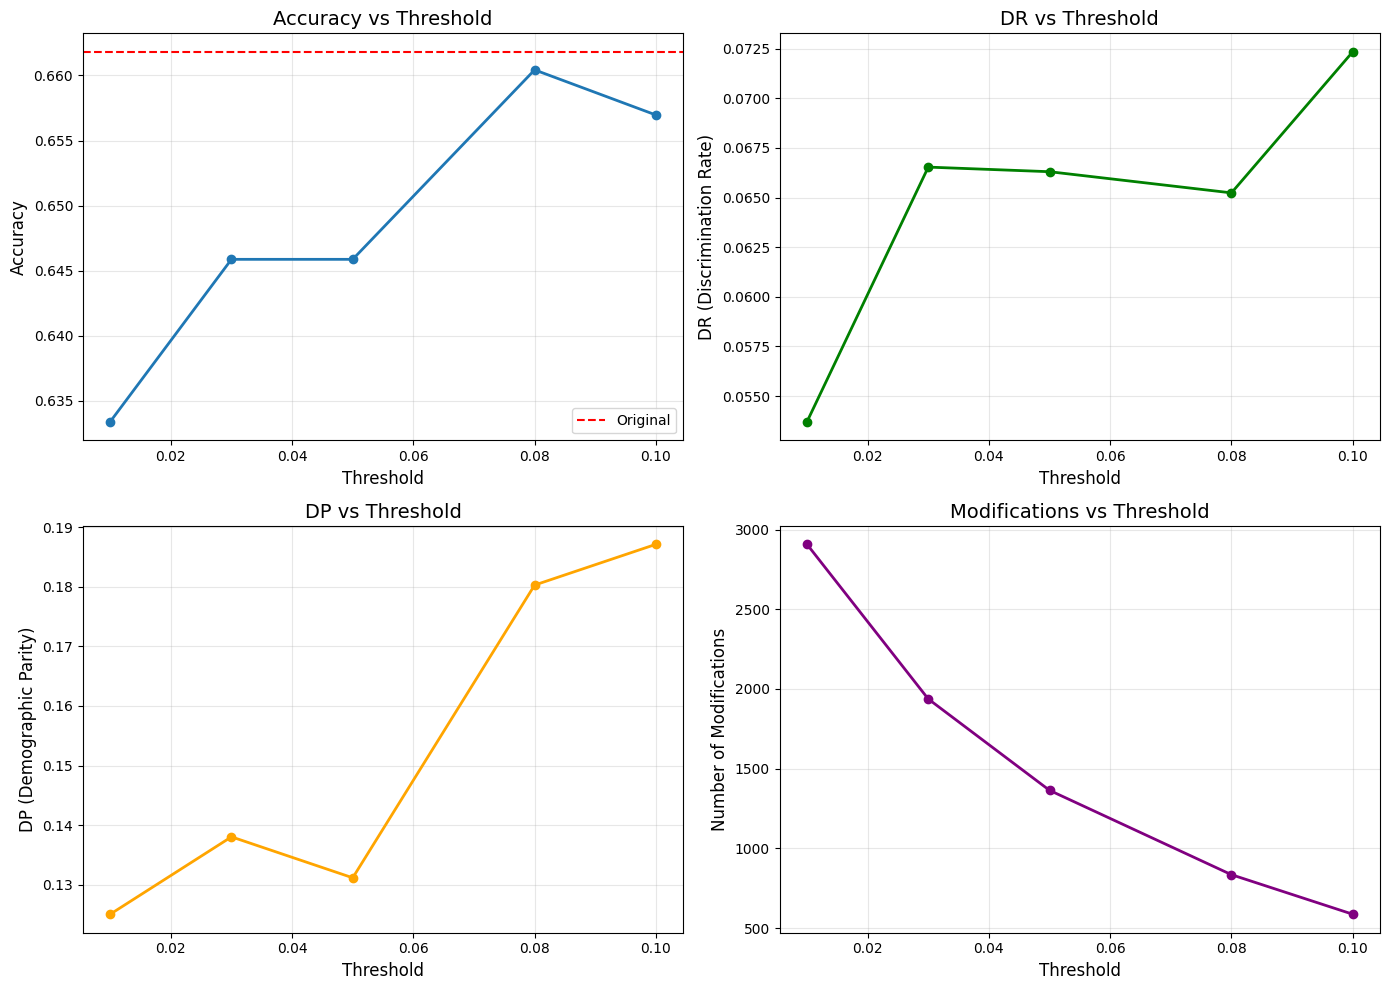

Plot saved to: threshold_analysis.png


In [51]:
# Plot threshold vs metrics relationship
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(df_comparison['threshold'], df_comparison['accuracy'], 'o-', linewidth=2)
axes[0, 0].axhline(y=original_accuracy, color='r', linestyle='--', label='Original')
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy vs Threshold', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# DR
axes[0, 1].plot(df_comparison['threshold'], df_comparison['DR'], 'o-', linewidth=2, color='green')
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('DR (Discrimination Rate)', fontsize=12)
axes[0, 1].set_title('DR vs Threshold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# DP
axes[1, 0].plot(df_comparison['threshold'], df_comparison['DP'], 'o-', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('DP (Demographic Parity)', fontsize=12)
axes[1, 0].set_title('DP vs Threshold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Number of modifications
axes[1, 1].plot(df_comparison['threshold'], df_comparison['num_modifications'], 'o-', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Number of Modifications', fontsize=12)
axes[1, 1].set_title('Modifications vs Threshold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: threshold_analysis.png")

### 6.2 Fairness-Accuracy Trade-off Visualization

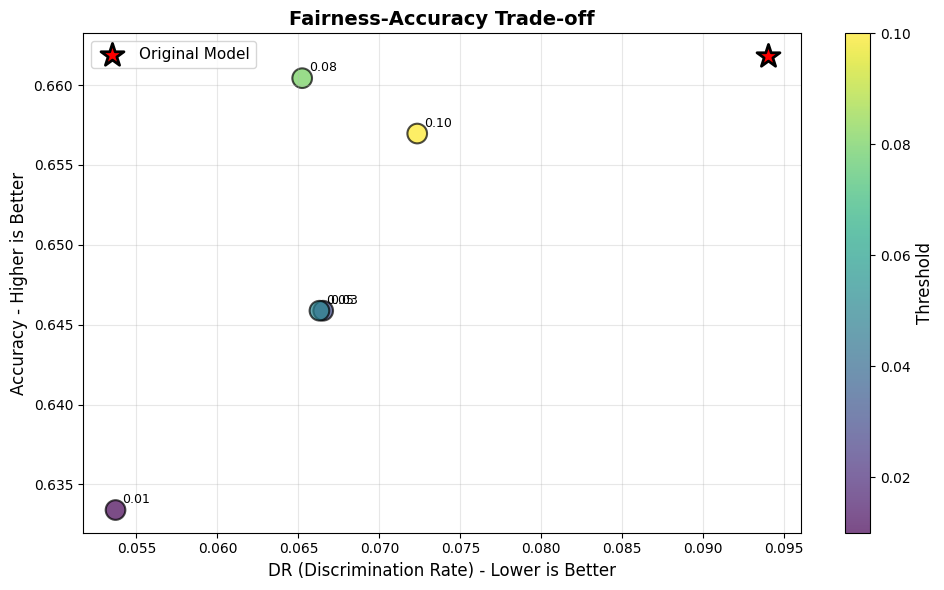

Plot saved to: fairness_accuracy_tradeoff.png


In [52]:
# Plot fairness-accuracy trade-off
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
scatter = ax.scatter(
    df_comparison['DR'], 
    df_comparison['accuracy'],
    c=df_comparison['threshold'],
    s=200,
    cmap='viridis',
    edgecolors='black',
    linewidth=1.5,
    alpha=0.7
)

# Add original model point
ax.scatter(
    result['original_metrics']['DR'],
    result['original_metrics']['accuracy'],
    color='red',
    s=300,
    marker='*',
    edgecolors='black',
    linewidth=2,
    label='Original Model',
    zorder=10
)

# Add threshold labels to each point
for i, row in df_comparison.iterrows():
    ax.annotate(
        f"{row['threshold']:.2f}",
        (row['DR'], row['accuracy']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Threshold', fontsize=12)

ax.set_xlabel('DR (Discrimination Rate) - Lower is Better', fontsize=12)
ax.set_ylabel('Accuracy - Higher is Better', fontsize=12)
ax.set_title('Fairness-Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fairness_accuracy_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: fairness_accuracy_tradeoff.png")

### 6.3 Metrics Comparison Chart

FairSHAP Binary One-Shot Modification (threshold=0.05)
1. Split the compas dataset into majority/minority groups by sensitive attribute and label
   X_train_majority_label0 shape: (2460, 18)
   X_train_majority_label1 shape: (2207, 18)
   X_train_minority_label0 shape: (710, 18)
   X_train_minority_label1 shape: (394, 18)
2. Initialize FairnessExplainer
3. Process minority group (match and compute SHAP values)
4. Process majority group (match and compute SHAP values)
   SHAP computation completed in 18.79 seconds
5. Combine SHAP values and filter by threshold
   Found 1364 features with SHAP values > 0.05
6. Calculate original model metrics on test set
   Original metrics - Accuracy: 0.6618, DR: 0.0940, DP: 0.1751, EO: 0.1795, PQP: 0.0625
7. Apply all 1364 modifications
8. Train new model with modified data
9. Evaluate modified model on test set
   Modified metrics - Accuracy: 0.6459, DR: 0.0663, DP: 0.1312, EO: 0.1026, PQP: 0.0540

SUMMARY
Modifications applied: 1364
Accuracy change: 

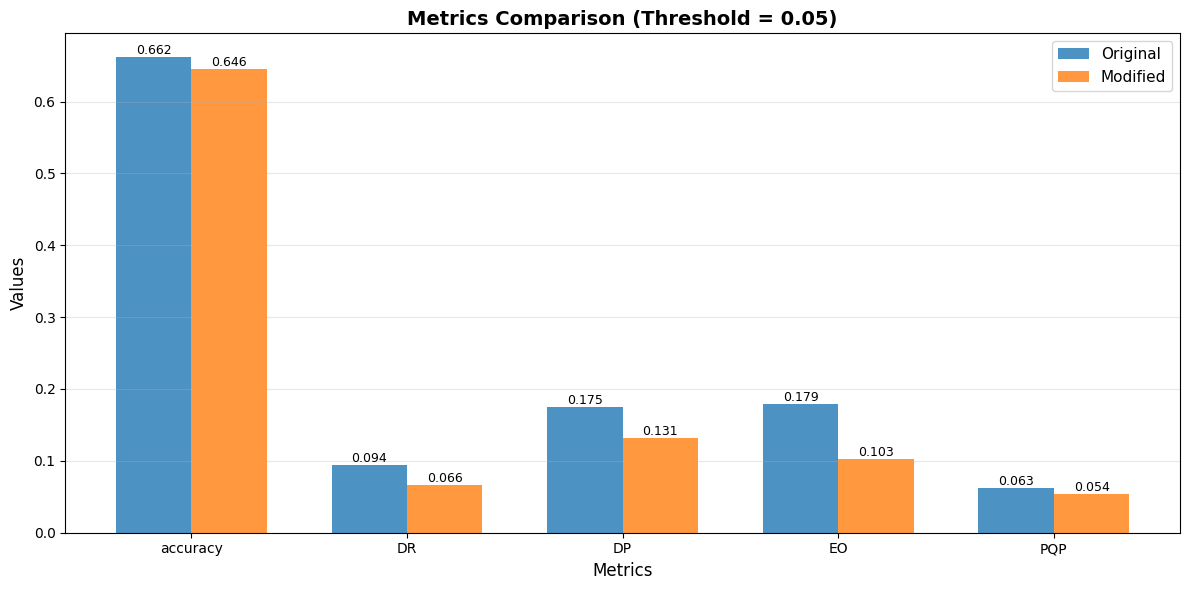

Plot saved to: metrics_comparison.png


In [53]:
# Select a threshold for detailed comparison
result_detail = fairshap.modify_binary_once(threshold=0.05, return_modified_features=False)

# Prepare data
metrics = ['accuracy', 'DR', 'DP', 'EO', 'PQP']
original_values = [result_detail['original_metrics'][m] for m in metrics]
modified_values = [result_detail['modified_metrics'][m] for m in metrics]

# Plot comparison bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original', alpha=0.8)
bars2 = ax.bar(x + width/2, modified_values, width, label='Modified', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom',
            fontsize=9
        )

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title(f'Metrics Comparison (Threshold = 0.05)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: metrics_comparison.png")

## Summary

This notebook demonstrates the usage of the new FairSHAP API:

### Key Advantages
1. **Fast**: One-shot modification without iteration
2. **Flexible**: Supports different thresholds and matching methods
3. **Practical**: Directly returns modified training data
4. **Comprehensive**: Supports both binary and multi-group scenarios

### Use Cases
- ✅ Rapid prototyping
- ✅ Hyperparameter tuning (threshold selection)
- ✅ Paper experiments and reporting
- ✅ Pre-deployment validation

### Recommended Workflow
1. Use `modify_binary_once()` or `modify_multi_once()` to quickly test multiple thresholds
2. Visualize fairness-accuracy trade-offs
3. Select optimal threshold
4. Get modified data for retraining or saving
5. For complete iteration curves, use the original `run()` method

## Appendix: Complete API Reference

### `modify_binary_once()`

**Parameters:**
- `threshold` (float): SHAP value threshold, default 0.05
- `return_modified_features` (bool): Whether to return modified data, default True

**Returns (dict):**
- `original_metrics`: Original model metrics
- `modified_metrics`: Modified model metrics
- `num_modifications`: Number of features modified
- `modified_X_train`: Modified training features (optional)
- `modified_y_train`: Training labels (optional)

### `modify_multi_once()`

**Parameters:**
- `threshold` (float): SHAP value threshold, default 0.05
- `return_modified_features` (bool): Whether to return modified data, default True

**Returns (dict):**
- `original_metrics`: Original model multi-group metrics
- `modified_metrics`: Modified model multi-group metrics
- `num_modifications`: Number of features modified
- `modified_X_train`: Modified training features (optional)
- `modified_y_train`: Training labels (optional)